In [1]:
!pip install segmentation-models-pytorch==0.3.3
!pip install albumentations==1.4.3
!pip install pycocotools
!pip install opencv-python
!pip install tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=c674f218235469d472b659b76114ed6a4185e3efa93909d600ffb1d86a2ad71b
  Stored in directory: /root/.cache/pip/wheels/9c/3f/43/e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e9a86fa65646af00689de81490fdac7b56a0c52f8736de9c4e0c7721c70e51a2
  Stored in directory: /root/.cache/pip/wheels/4c/01/56/40a48f75dbdfe167a0cb70d3b48913369a00ec5c4e9fed5f2b
Successfully built efficientnet-pytorc

In [2]:
!rm -rf train2017 val2017 annotations train2017.zip val2017.zip annotations_trainval2017.zip

!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

!unzip -q train2017.zip
!unzip -q val2017.zip
!unzip -q annotations_trainval2017.zip

--2025-11-19 11:01:19--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.16.2, 3.5.28.216, 52.217.169.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.16.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  12.9MB/s    in 20m 39s 

2025-11-19 11:21:58 (14.9 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-11-19 11:21:59--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.221.33, 3.5.20.16, 52.216.9.251, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.221.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  10.0MB/s  

In [3]:
from pycocotools.coco import COCO
import os

annFile = "./annotations/instances_train2017.json"
coco = COCO(annFile)

print("Total COCO images:", len(coco.imgs))


loading annotations into memory...
Done (t=14.87s)
creating index...
index created!
Total COCO images: 118287


In [4]:
import random

img_ids = coco.getImgIds()
selected_ids = random.sample(img_ids, 4000)
print("Selected:", len(selected_ids))


Selected: 4000


In [5]:
import numpy as np
from PIL import Image
from tqdm import tqdm

os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

for img_id in tqdm(selected_ids, desc="Generating dataset"):
    info = coco.loadImgs(img_id)[0]
    img_path = f"./train2017/{info['file_name']}"
    image = np.array(Image.open(img_path).convert("RGB"))

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((info['height'], info['width']), dtype=np.uint8)

    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))

    Image.fromarray(image).save(f"dataset/images/{info['file_name']}")
    Image.fromarray(mask * 255).save(f"dataset/masks/{info['file_name'].replace('.jpg', '.png')}")


Generating dataset: 100%|██████████| 4000/4000 [01:04<00:00, 61.64it/s]


In [6]:
files = sorted(os.listdir("dataset/images"))

train_files = files[:3200]
val_files   = files[3200:]


In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(p=0.3),
    A.Resize(512, 512),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(512, 512),
    ToTensorV2(),
])


In [8]:
from torch.utils.data import Dataset
import cv2
import torch

class CocoSegDataset(Dataset):
    def __init__(self, files, transform):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        img = cv2.imread(f"dataset/images/{fname}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(f"dataset/masks/{fname.replace('.jpg', '.png')}", cv2.IMREAD_GRAYSCALE)
        mask = (mask > 128).astype("uint8")

        aug = self.transform(image=img, mask=mask)
        img = aug["image"].float() / 255.0
        mask = aug["mask"].unsqueeze(0).float()

        return img, mask


In [9]:
from torch.utils.data import DataLoader

train_ds = CocoSegDataset(train_files, train_transform)
val_ds   = CocoSegDataset(val_files,   val_transform)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=2)

print(len(train_ds), len(val_ds))


3200 800


In [10]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice

def combined_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    dice = dice_loss(pred, target)
    return 0.5*bce + 0.5*dice


In [11]:
!pip install segmentation-models-pytorch==0.3.3 albumentations==1.4.3 --quiet


In [12]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# 1. Load U-Net
# -------------------------
model = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,         # decoder outputs 1 channel
    activation=None
)

# -------------------------
# 2. Freeze encoder
# -------------------------
for name, param in model.encoder.named_parameters():
    param.requires_grad = False

print("Encoder frozen ✔")

# -------------------------
# 3. Add extra layers AFTER U-Net output
# -------------------------
model.extra_head = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),   # FIX: input should be 1 channel
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 16, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(16, 1, 1)               # final 1-channel mask
)

# -------------------------
# 4. Modify forward
# -------------------------
old_forward = model.forward

def new_forward(x):
    x = old_forward(x)      # original U-Net output
    x = model.extra_head(x) # custom head
    return x

model.forward = new_forward

model.to(device)

print("🚀 Model ready, channels matched correctly!")


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


100%|██████████| 170M/170M [00:00<00:00, 288MB/s]


Encoder frozen ✔
🚀 Model ready, channels matched correctly!


In [16]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + smooth) / (union + smooth)
    return 1 - dice.mean()

def combined_loss(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target)
    d   = dice_loss(pred, target)
    return 0.5*bce + 0.5*d


optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


In [13]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------
# 1. Load U-Net
# -------------------------
model = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,         # decoder outputs 1 channel
    activation=None
)

# -------------------------
# 2. Freeze encoder
# -------------------------
for name, param in model.encoder.named_parameters():
    param.requires_grad = False

print("Encoder frozen ✔")

# -------------------------
# 3. Add extra layers AFTER U-Net output
# -------------------------
model.extra_head = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),   # FIX: input should be 1 channel
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 16, 3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(16, 1, 1)               # final 1-channel mask
)

# -------------------------
# 4. Modify forward
# -------------------------
old_forward = model.forward

def new_forward(x):
    x = old_forward(x)      # original U-Net output
    x = model.extra_head(x) # custom head
    return x

model.forward = new_forward

model.to(device)

print("🚀 Model ready, channels matched correctly!")


Encoder frozen ✔
🚀 Model ready, channels matched correctly!


In [17]:
from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        loss = combined_loss(preds, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    iou_total = 0
    count = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)

            val_loss += combined_loss(preds, masks).item()

            pr = (torch.sigmoid(preds) > 0.5).float()
            inter = (pr * masks).sum()
            union = ((pr + masks) > 0).float().sum()
            iou_total += (inter / (union + 1e-6)).item()
            count += 1

    avg_train = train_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    avg_iou = iou_total / count

    scheduler.step(avg_val)

    print(f"Epoch {epoch+1}/{num_epochs} | Train={avg_train:.4f} | Val={avg_val:.4f} | IoU={avg_iou:.4f}")


100%|██████████| 400/400 [03:57<00:00,  1.68it/s]


Epoch 1/5 | Train=0.4519 | Val=0.3337 | IoU=0.6389


100%|██████████| 400/400 [03:55<00:00,  1.70it/s]


Epoch 2/5 | Train=0.3460 | Val=0.3102 | IoU=0.6396


100%|██████████| 400/400 [03:55<00:00,  1.70it/s]


Epoch 3/5 | Train=0.3247 | Val=0.2953 | IoU=0.6580


100%|██████████| 400/400 [03:55<00:00,  1.70it/s]


Epoch 4/5 | Train=0.3154 | Val=0.2917 | IoU=0.6707


100%|██████████| 400/400 [03:55<00:00,  1.70it/s]


Epoch 5/5 | Train=0.3109 | Val=0.2862 | IoU=0.6757


In [18]:
torch.save(model.state_dict(), "final_unet_resnet101_best.pth")
print("✅ Model saved!")


✅ Model saved!


In [19]:
import torch
import numpy as np

def dice_coeff(pred, target, eps=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum()
    union = pred.sum() + target.sum()
    return (2 * inter + eps) / (union + eps)

def iou_coeff(pred, target, eps=1e-6):
    pred = (torch.sigmoid(pred) > 0.5).float()
    inter = (pred * target).sum()
    union = ((pred + target) > 0).float().sum()
    return (inter + eps) / (union + eps)

model.eval()
iou_total, dice_total, count = 0, 0, 0

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)

        iou_total += iou_coeff(preds, masks).item()
        dice_total += dice_coeff(preds, masks).item()
        count += 1

print("📊 FINAL RESULTS")
print("IoU:", iou_total / count)
print("Dice:", dice_total / count)


📊 FINAL RESULTS
IoU: 0.6756673058867455
Dice: 0.8019039738178253


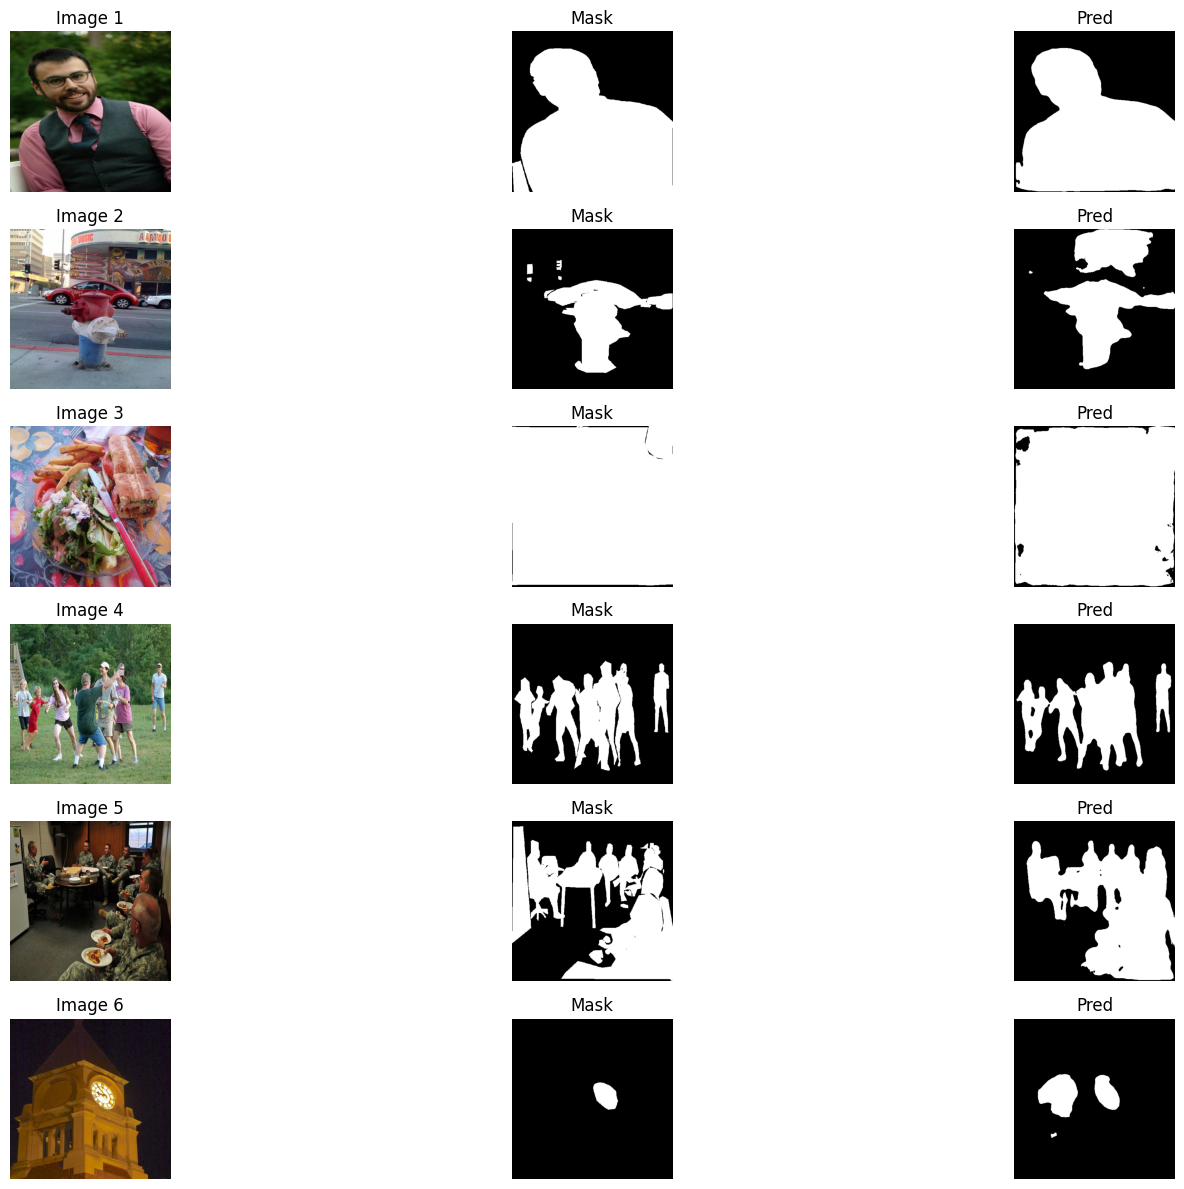

In [23]:
import matplotlib.pyplot as plt

model.eval()

# take 6 samples from validation loader
imgs, masks = next(iter(val_loader))
imgs, masks = imgs[:6].to(device), masks[:6].to(device)

preds = model(imgs)
preds = (torch.sigmoid(preds) > 0.5).float()

plt.figure(figsize=(18, 12))

for i in range(6):
    # ------------ INPUT IMAGE -------------
    plt.subplot(6, 3, i*3 + 1)
    plt.imshow(imgs[i].permute(1,2,0).cpu())
    plt.title(f"Image {i+1}")
    plt.axis("off")

    # ------------ GROUND TRUTH MASK -------------
    plt.subplot(6, 3, i*3 + 2)
    plt.imshow(masks[i][0].cpu(), cmap="gray")
    plt.title("Mask")
    plt.axis("off")

    # ------------ PREDICTED MASK -------------
    plt.subplot(6, 3, i*3 + 3)
    plt.imshow(preds[i][0].cpu(), cmap="gray")
    plt.title("Pred")
    plt.axis("off")

plt.tight_layout()
plt.show()
